# Colab Imports

In [87]:
from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation

In [88]:
!pip -q install langgraph langchain_openai langchain_community tiktoken konlpy langchain-pinecone pinecone-notebooks

# Settings & Loadings

In [89]:
import os
import json
import pandas as pd

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

PROFECT_DIR = os.path.join("/content/drive/MyDrive", "Profect SAE")
CSVs = os.path.join(PROFECT_DIR, "test_data/CSVs")
files = os.listdir(CSVs)
csv_files = [
    file for file in files
      if file.endswith(".csv")
]

df_one = pd.read_csv(os.path.join(CSVs, csv_files[0]))
print(df_one.iloc[0])

title      [종합] 김태희, 해외서 권총 강도 당했다…'연매출 1100억' 정샘물 "피해액 2...
url        https://m.entertain.naver.com/article/312/0000...
content    본문 바로가기 naver 엔터 뉴스 스포츠 사용자 링크 로그인 검색 홈 드라마 영화...
Name: 0, dtype: object


# Models, Schema & State
- `gpt-4o-mini`
- `text-embedding-3-large`

In [90]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

In [91]:
from pydantic import BaseModel, Field
from typing import Optional, List

class RequestDto(BaseModel):
  original_title: str = Field(..., min_length=1)
  original_url: str = Field(..., min_length=5, max_length=2083)
  original_content: str = Field(..., min_length=1)

class ResponseDto(BaseModel):
  korean_name: str
  english_name: str
  market: str
  ticker_code: str

class PreprocessingFlowState(BaseModel):
  route: str
  preprocessed_title: str
  preprocessed_url: str
  preprocessed_content: str

class RAGFlowState(BaseModel):
  route : str

class FlowState(BaseModel):
  request_dto: RequestDto
  response_dto: List[ResponseDto]
  preprocessing_flow_state: PreprocessingFlowState
  rag_flow_state: RAGFlowState

# Nodes

## Nodes & Tools for Preprocessing Flow
- `text_cleaning`
- `preprocessing_router_node`
- `naver_news_preprocessing_node`
- `naver_entertainment_preprocessing_node`
- `naver_sports_preprocessing_node`
- `youtube_preprocessing_node`

### Tools
- `text_cleaning`

In [92]:
def text_cleaning(text: str) -> str:
  """Cleaning text by removing unnecessary characters and spaces."""
  if isinstance(text, str):
      # Convert to lowercase
      text = text.lower()
      # Remove leading and trailing spaces
      text = text.strip()
      # Replace multiple spaces with a single space
      text = re.sub(r'\s+', ' ', text)
      # Remove special characters except for common ones
      text = re.sub(r'[^\w\s.,!?$%&@()-]', '', text)
  return text

### Router Node
- `prerocessing_router_node`

In [93]:
import re

def preprocessing_router_node(state: FlowState):
  request_dto = state.request_dto
  preprocessing_flow_state = state.preprocessing_flow_state

  youtube_pattern = r"^https?://(www\.)?youtube\.com"
  naver_news_pattern = r"^https?://n\.news\.naver\.com"
  naver_entertainment_pattern = r"^https?://m\.entertain\.naver\.com"
  naver_sports_pattern = r"^https?://m\.sports\.naver\.com"

  if re.match(naver_news_pattern, request_dto.original_url):
      route = "naver_news"

  elif re.match(naver_entertainment_pattern, request_dto.original_url):
      route = "naver_entertainment"

  elif re.match(naver_sports_pattern, request_dto.original_url):
      route = "naver_sports"

  elif re.match(youtube_pattern, request_dto.original_url):
      route = "youtube"
  else:
      route = "default"

  # Basic text cleaning
  preprocessing_flow_state.preprocessed_title = text_cleaning(request_dto.original_title)
  preprocessing_flow_state.preprocessed_content = text_cleaning(request_dto.original_content)
  preprocessing_flow_state.preprocessed_url = request_dto.original_url
  preprocessing_flow_state.route = route

  state.preprocessing_flow_state = preprocessing_flow_state
  return state

### Preprocessing Nodes Based on `flow_state.preprocessing_flow_state.route`
1. `naver_news_preprocessing_node`
2. `naver_entertainment_preprocessing_node`
3. `naver_sports_preprocessing_node`
4. `youtube_preprocessing_node`
5. `default_preprocessing_node`

---

1. `content_parser`

In [94]:
import re

def content_parser(text: str, remove_after: str = None, patterns: list = None) -> str:
  if not isinstance(text, str):
      return text

  if remove_after:
      text = re.sub(fr"{remove_after}.*", "", text, flags=re.IGNORECASE)

  if patterns:
    combined_pattern = "|".join(patterns)
    text = re.sub(combined_pattern, "", text, flags=re.IGNORECASE)

  # Remove excessive whitespace
  text = re.sub(r"\s+", " ", text).strip()

  return text

In [95]:
def preprocessing_naver_news_node(state: FlowState):
  preprocessing_flow_state = state.preprocessing_flow_state
  requestDto = state.request_dto
  """Cleans Naver News content."""
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="copyright .*?\. all rights reserved")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="기사 공유하기")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, patterns = [
          r"본문 바로가기", r"naver", r"뉴스", r"엔터", r"스포츠", r"날씨", r"프리미엄",
          r"사용자 링크", r"로그인", r"서비스", r"더보기", r"검색", r"언론사별", r"정치",
          r"경제", r"사회", r"생활문화", r"it과학", r"세계", r"랭킹", r"신문보기",
          r"오피니언", r"tv", r"팩트체크", r"알고리즘 안내", r"정정보도 모음"])
  return state

def preprocessing_naver_entertainment_node(state: FlowState):
  preprocessing_flow_state = state.preprocessing_flow_state
  requestDto = state.request_dto

  """Cleans Naver Entertainment content."""
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="copyright .*?\. all rights reserved")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="기사 공유하기")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, patterns = [
      r"본문 바로가기", r"naver", r"엔터", r"뉴스", r"스포츠", r"사용자 링크", r"로그인",
      r"검색", r"홈", r"드라마", r"영화", r"뮤직", r"연애", r"포토", r"랭킹", r"최신뉴스", r"연재", r"종합"])
  return state

def preprocessing_naver_sports_node(state: FlowState):
  preprocessing_flow_state = state.preprocessing_flow_state
  requestDto = state.request_dto
  """Cleans Naver Sports content."""
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="copyright .*?\. all rights reserved")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="기사 공유하기")
  return state

def preprocessing_youtube_node(state: FlowState):
  preprocessing_flow_state = state.preprocessing_flow_state
  requestDto = state.request_dto
  """Cleans YouTube transcript content."""
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, remove_after="더보기")
  preprocessing_flow_state.preprocessed_content = content_parser(requestDto.original_content, patterns = [r"kr", r"탐색", r"건너뛰기", r"만들기"])
  return state

Hold

In [96]:
from konlpy.tag import Okt

korean_stopwords = [
    "아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가",
    "으로", "로", "에게", "뿐이다", "의거하여", "근거하여", "입각하여", "기준으로", "예하면", "예를 들면", "예를 들자면",
    "저", "소인", "소생", "저희", "지말고", "하지마", "하지마라", "다른", "물론", "또한", "그리고", "비길수 없다", "해서는 안된다",
    "뿐만 아니라", "만이 아니다", "만은 아니다", "막론하고", "관계없이", "그치지 않다", "그러나", "그런데", "하지만", "든간에",
    "논하지 않다", "따지지 않다", "설사", "비록", "더라도", "아니면", "만 못하다", "하는 편이 낫다", "불문하고", "향하여",
    "향해서", "향하다", "쪽으로", "틈타", "이용하여", "타다", "오르다", "제외하고", "이 외에", "이 밖에", "하여야",
    "비로소", "한다면 몰라도", "외에도", "이곳", "여기", "부터", "기점으로", "따라서", "할 생각이다", "하려고하다",
    "이리하여", "그리하여", "그렇게 함으로써", "하지만", "일때", "할때", "앞에서", "중에서", "보는데서", "으로써", "로써",
    "까지", "해야한다", "일것이다", "반드시", "할줄알다", "할수있다", "할수있어", "임에 틀림없다", "한다면", "등", "등등",
    "제", "겨우", "단지", "다만", "할뿐", "딩동", "댕그", "대해서", "대하여", "대하면", "훨씬", "얼마나", "얼마만큼",
    "얼마큼", "남짓", "여", "얼마간", "약간", "다소", "좀", "조금", "다수", "몇", "얼마", "지만", "하물며", "또한",
    "그러나", "그렇지만", "하지만", "이외에도", "대해 말하자면", "뿐이다", "다음에", "반대로", "반대로 말하자면",
    "이와 반대로", "바꾸어서 말하면", "바꾸어서 한다면", "만약", "그렇지않으면", "까악", "툭", "딱", "삐걱거리다",
    "보드득", "비걱거리다", "꽈당", "응당", "해야한다", "에 가서", "각", "각각", "여러분", "각종", "각자", "제각기",
    "하도록하다", "와", "과", "그러므로", "그래서", "고로", "한 까닭에", "하기 때문에", "거니와", "이지만", "대하여",
    "관하여", "관한", "과연", "실로", "아니나다를가", "생각한대로", "진짜로", "한적이있다", "하곤하였다", "하", "하하",
    "허허", "아하", "거바", "와", "오", "왜", "어째서", "무엇때문에", "어찌", "하겠는가", "무슨", "어디", "어느곳",
    "더군다나", "하물며", "더욱이는", "어느때", "언제", "야", "이봐", "어이", "여보시오", "흐흐", "흥", "휴", "헉헉",
    "헐떡헐떡", "영차", "여차", "어기여차", "끙끙", "아야", "앗", "아야", "콸콸", "졸졸", "좍좍", "뚝뚝", "주룩주룩",
    "솨", "우르르", "그래도", "또", "그리고", "바꾸어말하면", "바꾸어말하자면", "혹은", "혹시", "답다", "및", "그에 따르는",
    "때가 되어", "즉", "지든지", "설령", "가령", "하더라도", "할지라도", "일지라도", "지든지", "몇", "거의", "하마터면",
    "인젠", "이젠", "된바에야", "된이상", "만큼", "어찌됏든", "그위에", "게다가", "점에서 보아", "비추어 보아", "고려하면",
    "하게될것이다", "일것이다", "비교적", "좀", "보다더", "비하면", "시키다", "하게하다", "할만하다", "의해서", "연이서",
    "이어서", "잇따라", "뒤따라", "뒤이어", "결국", "의지하여", "기대여", "통하여", "자마자", "더욱더", "불구하고",
    "얼마든지", "마음대로", "주저하지 않고", "곧", "즉시", "바로", "당장", "하자마자", "밖에 안된다", "하면된다", "그래",
    "그렇지", "요컨대", "다시 말하자면", "바꿔 말하면", "즉", "구체적으로", "말하자면", "시작하여", "시초에", "이상", "허",
    "헉", "허걱", "바와같이", "해도좋다", "해도된다", "게다가", "더구나", "하물며", "와르르", "팍", "퍽", "펄렁", "동안",
    "이래", "하고있었다", "이었다", "에서", "로부터", "까지", "예하면", "했어요", "해요", "함께", "같이", "더불어", "마저",
    "마저도", "양자", "모두", "습니다", "가까스로", "하려고하다", "즈음하여", "다른", "다른 방면으로", "해봐요", "습니까",
    "했어요", "말할것도 없고", "무릎쓰고", "개의치않고", "하는것만 못하다", "하는것이 낫다", "매", "매번", "들", "모", "어느것",
    "어느", "로써", "갖고말하자면", "어디", "어느쪽", "어느것", "어느해", "어느 년도", "라 해도", "언젠가", "어떤것", "어느것",
    "저기", "저쪽", "저것", "그때", "그럼", "그러면", "요만한걸", "그래", "그때", "저것만큼", "그저", "이르기까지", "할 줄 안다",
    "할 힘이 있다", "너", "너희", "당신", "어찌", "설마", "차라리", "할지언정", "할지라도", "할망정", "할지언정", "년", "월",
    "일", "하나", "둘", "셋", "넷", "다섯", "여섯", "일곱", "여덟", "아홉"
]


def default_preprocessing_node(state: FlowState):
  preprocessing_flow_state = state.preprocessing_flow_state
  content = preprocessing_flow_state.preprocessed_content
  okt = Okt()
  content_tokens = okt.morphs(content)

  result = [
      word for word in content_tokens
        if not word in korean_stopwords
      ]
  preprocessing_flow_state.preprocessed_content = " ".join(result)
  return state

## Nodes for Retriever & Generation Flow
- `embedding_node`
- `retriever_node`

In [97]:
def embedding_node(state = FlowState) -> FlowState:
  return state

In [98]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
from pydantic import BaseModel
from typing import List
from langchain_openai import OpenAIEmbeddings
import tiktoken

pc = Pinecone(api_key=userdata.get('PINECONE-API-KEY'))


def retriever_init(index_name: str, embeddings, namespace):
  index = pc.Index(index_name)
  vector_store = PineconeVectorStore(index=index, embedding=embeddings)
  return vector_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 2, "score_threshold": 0.65,"namespace": namespace},)

def retrieved_vector_parser(given_vectors, market_name="N/A"):
    return [
        ResponseDto(
            korean_name=vector.metadata.get("korean_name", "N/A"),
            english_name=vector.metadata.get("english_name", "N/A"),
            ticker_code=vector.metadata.get("ticker_code", "N/A"),
            market=market_name
        )
        for vector in given_vectors
    ]

def retriever_node(state: FlowState):
  preprocessing_flow_state = state.preprocessing_flow_state
  text = f"{preprocessing_flow_state.preprocessed_title}  {preprocessing_flow_state.preprocessed_content}"

  # Vector Store init
  embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
  kor_retriever = retriever_init("sae-embedded-stocks-kor", embeddings, "kospi-900")
  foriegn_retriever = retriever_init("sae-embedded-stocks-foriegn", embeddings, "nasdaq-1000")

  # Invoke
  kor_result = retrieved_vector_parser(kor_retriever.invoke(text), "KOSPI")
  foriegn_result = retrieved_vector_parser(foriegn_retriever.invoke(text),"NASDAQ")
  state.response_dto.extend(kor_result)
  state.response_dto.extend(foriegn_result)
  return state

# Flows

## Preprocessing Flow

In [99]:
from langgraph.graph import StateGraph, START, END

preprocessing_graph = StateGraph(state_schema=FlowState)

# Registering Noes

## router
preprocessing_graph.add_node("preprocessing_router_node", preprocessing_router_node)

## preprocessing
preprocessing_graph.add_node("naver_news_preprocessing_node", preprocessing_naver_news_node)
preprocessing_graph.add_node("naver_entertainment_preprocessing_node", preprocessing_naver_entertainment_node)
preprocessing_graph.add_node("naver_sports_preprocessing_node", preprocessing_naver_sports_node)
preprocessing_graph.add_node("youtube_preprocessing_node", preprocessing_youtube_node)
preprocessing_graph.add_node("default_preprocessing_node", default_preprocessing_node)


# Registering Edges
# Conditional Edges
preprocessing_graph.add_edge(START, "preprocessing_router_node")

preprocessing_graph.add_conditional_edges(
    "preprocessing_router_node",
    lambda flow_state: flow_state.preprocessing_flow_state.route,
    {
        "naver_news": "naver_news_preprocessing_node",
        "naver_entertainment": "naver_entertainment_preprocessing_node",
        "naver_sports": "naver_sports_preprocessing_node",
        "youtube": "youtube_preprocessing_node",
        # "default": "default_preprocessing_node",
        "default": END,
    }
)

# preprocessing_graph.add_edge("naver_news_preprocessing_node", "default_preprocessing_node")
# preprocessing_graph.add_edge("naver_entertainment_preprocessing_node", "default_preprocessing_node")
# preprocessing_graph.add_edge("naver_sports_preprocessing_node", "default_preprocessing_node")
# preprocessing_graph.add_edge("youtube_preprocessing_node", "default_preprocessing_node")
# preprocessing_graph.add_edge("default_preprocessing_node", END)
preprocessing_graph.add_edge("naver_news_preprocessing_node", END)
preprocessing_graph.add_edge("naver_entertainment_preprocessing_node", END)
preprocessing_graph.add_edge("naver_sports_preprocessing_node", END)
preprocessing_graph.add_edge("youtube_preprocessing_node", END)

# agent Init
preprocessing_agent = preprocessing_graph.compile()

### Visualization

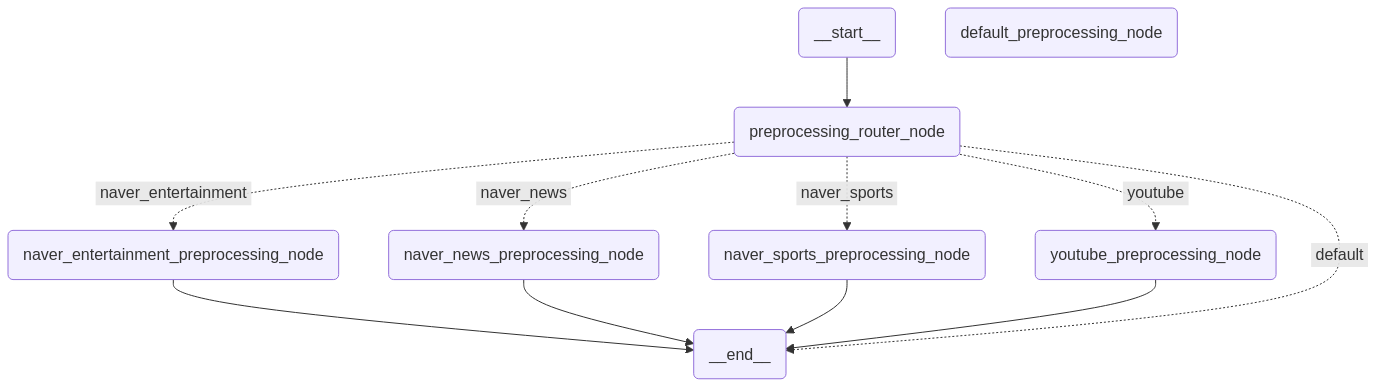

In [100]:
# Visualize your graph
from IPython.display import Image, display
png = preprocessing_agent.get_graph().draw_mermaid_png()
display(Image(png))

## Retriever & Generation Flow

In [101]:
from langgraph.graph import StateGraph, START, END

rag_graph = StateGraph(state_schema=FlowState)

# Registering Noes
rag_graph.add_node("embedding_node", embedding_node)
rag_graph.add_node("retriever_node", retriever_node)

# Registering Edges
rag_graph.add_edge(START, "embedding_node")
rag_graph.add_edge("embedding_node", "retriever_node")
rag_graph.add_edge("retriever_node", END)

# Flow Init
rag_agent = rag_graph.compile()

### Visualization

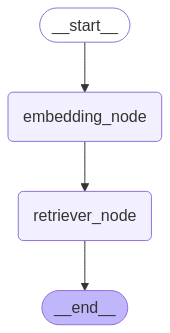

In [102]:
# Visualize your graph
from IPython.display import Image, display
png = rag_agent.get_graph().draw_mermaid_png()
display(Image(png))

# Testing

In [103]:
def flow_init(row: pd.Series) -> FlowState:
  request_dto = RequestDto(
      original_title=row.title,
      original_url=row.url,
      original_content=row.content
  )
  response = []
  preprocessing_flow_state = PreprocessingFlowState(
      route="",
      preprocessed_title="",
      preprocessed_url="",
      preprocessed_content=""
  )
  rag_flow_state = RAGFlowState(
      route=""
  )
  flow_state = FlowState(
      request_dto=request_dto,
      response_dto=response,
      preprocessing_flow_state=preprocessing_flow_state,
      rag_flow_state=rag_flow_state
  )
  return flow_state

In [105]:
before_length_total = 0
after_length_total = 0
for row in df_one.itertuples(index=False):
  original_flow_state = flow_init(row)
  print("Title: ", original_flow_state.request_dto.original_title + "\n")

  print("Preprocessing Flow")
  preprocessed_flow_state = preprocessing_agent.invoke(original_flow_state)
  before_length = len(preprocessed_flow_state['request_dto'].original_content)
  after_length = len(preprocessed_flow_state['preprocessing_flow_state'].preprocessed_content)
  print("Before: "+str(before_length))
  print("After: " +str(after_length))
  print("")
  before_length_total += before_length
  after_length_total += after_length

  print("RAG Flow")
  rag_state = FlowState(
      request_dto=preprocessed_flow_state['request_dto'],
      response_dto=preprocessed_flow_state['response_dto'],
      rag_flow_state=preprocessed_flow_state['rag_flow_state'],
      preprocessing_flow_state=preprocessed_flow_state['preprocessing_flow_state'],
  )

  response_state = rag_agent.invoke(rag_state)
  for response in response_state['response_dto']:
    print("KOR Name:",response.korean_name + "(" + response.market +")")
  print("")
  print("------------\n")

print("Average reduction by length")
print(int((before_length_total - after_length_total)/len(df_one)))

Title:  [종합] 김태희, 해외서 권총 강도 당했다…'연매출 1100억' 정샘물 "피해액 2000만원"('백억짜리')

Preprocessing Flow
Before: 2678
After: 2526

RAG Flow
KOR Name: 티와이홀딩스(KOSPI)
KOR Name: 시프트업(KOSPI)
KOR Name: 울타 뷰티(NASDAQ)
KOR Name: 타불라(NASDAQ)

------------

Title:  연예계 불화 또 터졌다…곽준빈, 유명 여배우에 막말 "네가 무슨 배우야" ('전현무계획')

Preprocessing Flow
Before: 2665
After: 2517

RAG Flow
KOR Name: IHQ(KOSPI)
KOR Name: NAVER(KOSPI)
KOR Name: 넥스타 미디어 그룹(NASDAQ)
KOR Name: 넷플릭스(NASDAQ)

------------

Title:  시우민 '뮤뱅' 출연 거부 여파..이무진, '리무진서비스' 녹화 돌연 불참 [스타이슈]

Preprocessing Flow
Before: 3408
After: 3227

RAG Flow
KOR Name: IHQ(KOSPI)
KOR Name: 키다리스튜디오(KOSPI)
KOR Name: 넥스타 미디어 그룹(NASDAQ)
KOR Name: 윅스닷컴(NASDAQ)

------------

Title:  '우효광♥' 추자현, 폭풍 성장 子와 애틋한 재회.."떨어져 지내 힘들었다"

Preprocessing Flow
Before: 2808
After: 2647

RAG Flow


KOR Name: IHQ(KOSPI)
KOR Name: NAVER(KOSPI)

------------

Title:  '이혼숙려캠프' 온가족 무직, "생활비= 父 유산 2억 다 써" '충격'

Preprocessing Flow
Before: 2351
After: 2204

RAG Flow
KOR Name: NAVER(KOSPI)
KOR Name: IHQ(KOSPI)
KOR Name: 넥스타 미디어 그룹(NASDAQ)
KOR Name: 넷플릭스(NASDAQ)

------------

Title:  與 "홍장원 이어 곽종근도 진술 조작" "내란 아닌 내란몰이 사기극"

Preprocessing Flow
Before: 9968
After: 9379

RAG Flow


KOR Name: 호전실업(KOSPI)
KOR Name: 한화갤러리아(KOSPI)

------------

Title:  안보실장 "한미, 대북정책 반드시 사전에 긴밀히 공조하기로"

Preprocessing Flow
Before: 4226
After: 3945

RAG Flow
KOR Name: 콘텐트리중앙(KOSPI)
KOR Name: 현대퓨처넷(KOSPI)
KOR Name: 트럼프 미디어 & 테크놀로지 그룹(NASDAQ)
KOR Name: 뉴스 코퍼레이션 Class B(NASDAQ)

------------

Title:  선관위 사무총장 “특혜 채용 당사자 봐주지 않을것”…추가 조치 예고

Preprocessing Flow
Before: 8982
After: 8361

RAG Flow


KOR Name: 에스원(KOSPI)
KOR Name: 한화투자증권(KOSPI)

------------

Title:  '민가 오폭' 공군, 모든 항공기 비행 제한…조종사 교육 착수

Preprocessing Flow
Before: 9033
After: 8444

RAG Flow


KOR Name: 남양유업(KOSPI)
KOR Name: CJ제일제당(KOSPI)

------------

Title:  [속보] 이재명 “국민의힘 제안 배우자 상속세 면제·폐지 동의”

Preprocessing Flow
Before: 4617
After: 4428

RAG Flow
KOR Name: 한세예스24홀딩스(KOSPI)
KOR Name: 현대퓨처넷(KOSPI)
KOR Name: 리갈줌닷컴(NASDAQ)
KOR Name: 모닝스타(NASDAQ)

------------

Title:  "한국인들 신라면·새우깡 없인 못 사는데"…가격 오른다

Preprocessing Flow
Before: 9292
After: 8723

RAG Flow
KOR Name: 농심(KOSPI)
KOR Name: 신풍(KOSPI)
KOR Name: 세즐(NASDAQ)
KOR Name: 데이브(NASDAQ)

------------

Title:  민주 "홈플러스 법정관리 일파만파…MBK 과도한 탐욕이 원인"

Preprocessing Flow
Before: 8673
After: 8053

RAG Flow
KOR Name: 한화갤러리아(KOSPI)
KOR Name: 한화투자증권(KOSPI)
KOR Name: 헬스에퀴티(NASDAQ)

------------

Title:  한국면세점협회 제10대 회장에 김동하 롯데면세점 대표이사

Preprocessing Flow
Before: 8311
After: 7735

RAG Flow
KOR Name: 현대홈쇼핑(KOSPI)
KOR Name: 현대퓨처넷(KOSPI)
KOR Name: 지프 데이비스(NASDAQ)
KOR Name: 뉴스 코퍼레이션 Class B(NASDAQ)

------------

Title:  지난달 선박수주 中 1위…韓은 다시 2위로

Preprocessing Flow
Before: 8658
After: 8095

RAG Flow
KOR Name: 롯데손해보험(KOSPI)
KOR Name: KCC글라스(KOSPI)

KOR Name: 트럼프 미디어 & 테크놀로지 그룹(NASDAQ)
KOR Name: 로빈후드(NASDAQ)

------------

Title:  트럼프 "나토 국가들, 방위비 안 내면 방어 안 할 것"

Preprocessing Flow
Before: 8950
After: 8365

RAG Flow
KOR Name: 티와이홀딩스(KOSPI)
KOR Name: IHQ(KOSPI)
KOR Name: 넷플릭스(NASDAQ)

------------

Title:  "딥시크보다 저비용 고성능 AI 모델" 내놓은 알리바바 주가 급등

Preprocessing Flow
Before: 8807
After: 8224

RAG Flow
KOR Name: 현대퓨처넷(KOSPI)
KOR Name: 현대홈쇼핑(KOSPI)
KOR Name: 모닝스타(NASDAQ)
KOR Name: 아마존닷컴(NASDAQ)

------------

Title:  ‘트럼프 실세’ 머스크 반감에 애꿎은 이곳만 불탔다

Preprocessing Flow
Before: 9359
After: 8751

RAG Flow



------------

Title:  이정후, 시범경기 2호 홈런 폭발! (feat.현지해설) #SPOTIME - YouTube

Preprocessing Flow
Before: 2021
After: 1999

RAG Flow


KOR Name: 타불라(NASDAQ)

------------

Title:  뜨거운 열간 단조 기술로 대형 베어링을 만드는 과정. 놀라운 한국의 볼 베어링 공장 - YouTube

Preprocessing Flow
Before: 5695
After: 5667

RAG Flow
KOR Name: 한국특강(KOSPI)
KOR Name: 제일연마(KOSPI)
KOR Name: 카이저 알루미늄(NASDAQ)
KOR Name: 조메트리(NASDAQ)

------------

Title:  일본 귀족이 평가하는 QWER... - YouTube

Preprocessing Flow
Before: 1758
After: 1729

RAG Flow


KOR Name: 타불라(NASDAQ)
KOR Name: 메타(NASDAQ)

------------

Title:  [휴먼다큐 자식이 좋다] EP.02 '엄마라는 이름으로' Jamie맘 이소담 씨의 아찔한 라이딩 (20250225 방송) #이수지 #핫이슈지 #자식이좋다 - YouTube

Preprocessing Flow
Before: 2085
After: 2059

RAG Flow
KOR Name: CJ제일제당(KOSPI)
KOR Name: IHQ(KOSPI)
KOR Name: 줌 커뮤니케이션스(NASDAQ)
KOR Name: 타불라(NASDAQ)

------------

Title:  국내 최초의 슈퍼카 제조업체(가 될뻔했던) 어울림 모터스에 대해 알아보자 - YouTube

Preprocessing Flow
Before: 1838
After: 1818

RAG Flow


KOR Name: 타불라(NASDAQ)
KOR Name: 리버티 미디어 Series A(NASDAQ)

------------

Title:  '불붙은 무역전쟁' 미국 최대 25% 관세 시작…뉴욕증시-가상화폐 모두 '타격' / SBS 8뉴스 - YouTube

Preprocessing Flow
Before: 5251
After: 5182

RAG Flow


KOR Name: 교촌에프앤비(KOSPI)

------------

Title:  [속보]오락가락 트럼프 관세 피로감…나스닥 2.6%↓

Preprocessing Flow
Before: 6140
After: 6135

RAG Flow
KOR Name: 현대퓨처넷(KOSPI)
KOR Name: 한국단자(KOSPI)
KOR Name: 트레이드웹 마켓(NASDAQ)
KOR Name: 나스닥(NASDAQ)

------------

Title:  트럼프 행정부의 관세 정책과 통화 정책: 감세와 관세의 상관 관계

Preprocessing Flow
Before: 3877
After: 3876

RAG Flow
KOR Name: F&F홀딩스(KOSPI)
KOR Name: 트럼프 미디어 & 테크놀로지 그룹(NASDAQ)
KOR Name: 인터랙티브 브로커스 그룹(NASDAQ)

------------

Average reduction by length
361
